<h1 align='center'>Hyperparameter Tuning</h1>

# Introduction

Based on **Chapter 11 of "Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow",** this notebook documents my practical exploration of advanced techniques for training deep neural networks. Focused on tackling challenges like vanishing/exploding gradients, hyperparameter tuning, and optimization strategies, the code demonstrates key concepts using TensorFlow/Keras and the Fashion MNIST dataset. Highlights include:

* Weight initialization (Glorot, He).
* Activation functions (Leaky ReLU, SELU).
* Batch normalization and gradient clipping.
* Transfer learning via layer reuse.
* Optimizers (Momentum, RMSProp, Adam, Nadam).
* Learning Rate Scheduling
* Regularization

All experiments emphasize practical implementation over theoretical depth, aligning with the book’s learn-by-doing approach.



# The Vanishing/Exploding Gradients Problems

## Glorot & He Initialization

In [1]:
import tensorflow as tf
import numpy as np

In [2]:
dense = tf.keras.layers.Dense(50, activation='relu', kernel_initializer='he_normal')

In [3]:
# Alternative using VarianceScaling

he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                                    distribution='uniform')
dense = tf.keras.layers.Dense(50, activation='sigmoid',
                             kernel_initializer=he_avg_init)

## Better Activation Functions

### Leaky ReLU

In [4]:
leaky_relu = tf.keras.layers.LeakyReLU(negative_slope=0.2)
dense = tf.keras.layers.Dense(50, activation=leaky_relu,
                             kernel_initializer='he_normal')

In [5]:
model = tf.keras.Sequential([
    #[...]  more layers
    tf.keras.layers.Dense(50, kernel_initializer='he_normal'),  #no activation
    tf.keras.layers.LeakyReLU(negative_slope=0.2),  #activation as seperate layer
    #[...]  more layers
])

**Similarly other activations can be used by just mentioning in activation hyperparameter.**

### Extra work:
Example of self-regularized network using SELU.

Neural net for FASHION MNIST unind 100 hidden layers, using SELU Activation:

In [ ]:
tf.random.set_seed(42)
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(28, 28)))
model.add(tf.keras.layers.Flatten())

for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [7]:
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             metrics=['accuracy'])

Now training the model, and before training, normalizing them with mean 0 and standard deviation 1:

In [8]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [9]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [10]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True)
X_train_Scaled = (X_train - pixel_means) / pixel_std
X_valid_Scaled = (X_valid - pixel_means) / pixel_std
X_test_Scaled = (X_test - pixel_means) / pixel_std

In [11]:
history = model.fit(X_train_Scaled, y_train, epochs=5, 
                   validation_data=(X_valid_Scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 28s 13ms/step - accuracy: 0.3547 - loss: 1.6762 - val_accuracy: 0.6444 - val_loss: 0.9574
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6708 - loss: 0.8951 - val_accuracy: 0.7206 - val_loss: 0.8165
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7390 - loss: 0.7205 - val_accuracy: 0.7768 - val_loss: 0.6274
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7695 - loss: 0.6317 - val_accuracy: 0.7754 - val_loss: 0.6362
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7885 - loss: 0.5779 - val_accuracy: 0.7792 - val_loss: 0.6136


In [12]:
model.evaluate(X_test_Scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7734 - loss: 0.6449


[0.6428771615028381, 0.7703999876976013]

**Now try using ReLU activation function:**

In [13]:
tf.random.set_seed(42)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(28, 28)))  # Explicit Input layer
model.add(tf.keras.layers.Flatten())  # No input_shape argument

for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [14]:
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
             metrics=['accuracy'])

In [15]:
history = model.fit(X_train_Scaled, y_train, epochs=5,
                   validation_data=(X_valid_Scaled, y_valid))

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.1571 - loss: 2.1017 - val_accuracy: 0.3456 - val_loss: 1.6278
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.3895 - loss: 1.4761 - val_accuracy: 0.4188 - val_loss: 1.3741
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - accuracy: 0.4930 - loss: 1.1730 - val_accuracy: 0.6136 - val_loss: 0.9336
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5941 - loss: 0.9603 - val_accuracy: 0.6232 - val_loss: 0.9482
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.6355 - loss: 0.8921 - val_accuracy: 0.6888 - val_loss: 0.8027


In [16]:
model.evaluate(X_test_Scaled, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6715 - loss: 0.8253


[0.8275880813598633, 0.6708999872207642]

This shows that with activation SELU and initializer LeCun Normal, the accuracy on test set was 77.34% and the loss was 64.49%. Whereas, using ReLU anctivation and He Normal initializer, we are getting accuracy of 67.15% and loss of 82.53%.

**This shows that SELU is better activation as compared to ReLU, for this dataset.**

## Batch Normalization

In [22]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

**Method 1, adding `BatchNormalization()` layer after every hidden layer and input layer:**

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

In [26]:
# Parameters of first BN layer
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

In [27]:
# Extra code: Check if model works

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.7563 - loss: 0.7077 - val_accuracy: 0.8554 - val_loss: 0.3975
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8562 - loss: 0.4074 - val_accuracy: 0.8670 - val_loss: 0.3646


**Alternate Method: `BatchNormalization()` before activation.**

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [30]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7406 - loss: 0.7953 - val_accuracy: 0.8500 - val_loss: 0.4289
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8498 - loss: 0.4342 - val_accuracy: 0.8616 - val_loss: 0.3871


## Gradient Clipping

**All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:**

In [34]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8685 - loss: 0.3778 - val_accuracy: 0.8650 - val_loss: 0.3732
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8815 - loss: 0.3413 - val_accuracy: 0.8660 - val_loss: 0.3650


In [35]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8929 - loss: 0.3093 - val_accuracy: 0.8750 - val_loss: 0.3447
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8984 - loss: 0.2918 - val_accuracy: 0.8774 - val_loss: 0.3432


# Reusing Pretrainred Layers

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

In [36]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4606 - loss: 1.5616 - val_accuracy: 0.7398 - val_loss: 0.7503
Epoch 2/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7553 - loss: 0.6971 - val_accuracy: 0.8085 - val_loss: 0.5577
Epoch 3/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8172 - loss: 0.5455 - val_accuracy: 0.8433 - val_loss: 0.4740
Epoch 4/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8486 - loss: 0.4683 - val_accuracy: 0.8581 - val_loss: 0.4217
Epoch 5/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8624 - loss: 0.4180 - val_accuracy: 0.8644 - val_loss: 0.3872
Epoch 6/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8715 - loss: 0.3840 - val_accuracy: 0.8716 - val_loss: 0.3634
Epoch 7/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8776 - loss: 0.3597 - val_accuracy: 0.8757 - val_loss: 0.3459
Epoch 8/20
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8834 - loss: 0.3416 - 

In [41]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28, 28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4750 - loss: 0.7032 - val_accuracy: 0.5608 - val_loss: 0.6785
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6443 - loss: 0.6592 - val_accuracy: 0.6825 - val_loss: 0.6418
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7884 - loss: 0.6199 - val_accuracy: 0.7695 - val_loss: 0.6110
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8356 - loss: 0.5871 - val_accuracy: 0.8259 - val_loss: 0.5844
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8678 - loss: 0.5590 - val_accuracy: 0.8655 - val_loss: 0.5605
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8871 - loss: 0.5344 - val_accuracy: 0.8971 - val_loss: 0.5388
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8989 - loss: 0.5118 - val_accuracy: 0.9080 - val_loss: 0.5192
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9197 - loss: 0.4915 - val_accuracy: 0.9159 - val_loss: 0.5011


[0.36785927414894104, 0.9375]

**Model B reaches around 93% accuracy on the test set. Now let's try reusing the pretrained model A:**

**Note:** Since `Model_B_on_A` is built on `Model_A`, so when we train it, it will also affect the original model. To avoid it we must create clone of `Model_A`, before compilling and training it.

In [42]:
tf.random.set_seed(42)

model_A = tf.keras.models.load_model('my_model_A.keras')

model_A_clone = tf.keras.models.clone_model(model_A)   #creating clone
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [43]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In the code above, the hidden layers taken from `Model_A` are stoped from training (i.e. *Freezed*) as they might disturb the initial training of new items.

In the code below, first 4 epoch is trained without affecting initial layers taken from `model_A`, and after that they are *unfreezed*, and remaining 16 epochs are done including all layers in the new model, `model_B_on_A`.

In [44]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.4430 - loss: 1.1137 - val_accuracy: 0.5292 - val_loss: 0.6882
Epoch 2/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5430 - loss: 0.6768 - val_accuracy: 0.7428 - val_loss: 0.5374
Epoch 3/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7533 - loss: 0.5453 - val_accuracy: 0.7982 - val_loss: 0.5021
Epoch 4/4
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7936 - loss: 0.5107 - val_accuracy: 0.8239 - val_loss: 0.4895
Epoch 1/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8249 - loss: 0.4886 - val_accuracy: 0.8447 - val_loss: 0.4548
Epoch 2/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8484 - loss: 0.4517 - val_accuracy: 0.8704 - val_loss: 0.4243
Epoch 3/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8781 - loss: 0.4192 - val_accuracy: 0.8833 - val_loss: 0.3983
Epoch 4/16
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9109 - loss: 0.3915 - val_accuracy: 0.8942 - val_loss: 0.3761
Epoc

In [45]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9330 - loss: 0.2590


[0.2683044672012329, 0.9240000247955322]

**This shows that the accuracy is aproximately same i.e. around 93% in both cases when `model_A` is not used and used.
Whereas, the loss has reduced from around 36% to 25%, i.e. around 30% fall. That's good!</br>
But we must stay cautious, as with change in random seed the results may vary significantly.**

# Faster Optimizers

In [ ]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(28, 28)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

## Momentum

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

history_momentum = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6686 - loss: 0.9729 - val_accuracy: 0.8152 - val_loss: 0.5025
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8303 - loss: 0.4859 - val_accuracy: 0.8320 - val_loss: 0.4501
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8477 - loss: 0.4352 - val_accuracy: 0.8468 - val_loss: 0.4182
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8581 - loss: 0.4051 - val_accuracy: 0.8536 - val_loss: 0.3965
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8647 - loss: 0.3833 - val_accuracy: 0.8564 - val_loss: 0.3856
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8693 - loss: 0.3664 - val_accuracy: 0.8598 - val_loss: 0.3750
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8746 - loss: 0.3523 - val_accuracy: 0.8624 - val_loss: 0.3692
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8788 - loss: 0.3402 - 

## Nesterov Accelerated Gradient

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9,
                                    nesterov=True)

history_nesterov = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6790 - loss: 0.9610 - val_accuracy: 0.8308 - val_loss: 0.4829
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8321 - loss: 0.4762 - val_accuracy: 0.8422 - val_loss: 0.4361
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8491 - loss: 0.4272 - val_accuracy: 0.8508 - val_loss: 0.4109
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8591 - loss: 0.3984 - val_accuracy: 0.8572 - val_loss: 0.3962
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8659 - loss: 0.3784 - val_accuracy: 0.8602 - val_loss: 0.3864
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8715 - loss: 0.3625 - val_accuracy: 0.8616 - val_loss: 0.3809
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8760 - loss: 0.3485 - val_accuracy: 0.8628 - val_loss: 0.3768
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8810 - loss: 0.3361 - 

## AdaGrad

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001)

history_adagrad = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5474 - loss: 1.3950 - val_accuracy: 0.7780 - val_loss: 0.6809
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7841 - loss: 0.6633 - val_accuracy: 0.8094 - val_loss: 0.5768
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8097 - loss: 0.5774 - val_accuracy: 0.8206 - val_loss: 0.5320
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8210 - loss: 0.5366 - val_accuracy: 0.8292 - val_loss: 0.5057
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8284 - loss: 0.5113 - val_accuracy: 0.8322 - val_loss: 0.4882
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8339 - loss: 0.4937 - val_accuracy: 0.8342 - val_loss: 0.4751
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8383 - loss: 0.4803 - val_accuracy: 0.8370 - val_loss: 0.4652
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8418 - loss: 0.4697 - 

## RMSProp

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

history_rmsprop = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7596 - loss: 0.6644 - val_accuracy: 0.8356 - val_loss: 0.4472
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8554 - loss: 0.4035 - val_accuracy: 0.8492 - val_loss: 0.4193
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8670 - loss: 0.3703 - val_accuracy: 0.8316 - val_loss: 0.5156
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8739 - loss: 0.3576 - val_accuracy: 0.8192 - val_loss: 0.5826
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8777 - loss: 0.3473 - val_accuracy: 0.8438 - val_loss: 0.4659
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8811 - loss: 0.3436 - val_accuracy: 0.8312 - val_loss: 0.6335
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8821 - loss: 0.3406 - val_accuracy: 0.8292 - val_loss: 0.6140
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8841 - loss: 0.3434 - 

## Adam Optimization

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

history_adam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7705 - loss: 0.6496 - val_accuracy: 0.8336 - val_loss: 0.4201
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8589 - loss: 0.3880 - val_accuracy: 0.8256 - val_loss: 0.4459
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8723 - loss: 0.3454 - val_accuracy: 0.8552 - val_loss: 0.3939
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8823 - loss: 0.3172 - val_accuracy: 0.8608 - val_loss: 0.3855
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8900 - loss: 0.2970 - val_accuracy: 0.8642 - val_loss: 0.3701
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8952 - loss: 0.2793 - val_accuracy: 0.8684 - val_loss: 0.3787
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9008 - loss: 0.2678 - val_accuracy: 0.8740 - val_loss: 0.3592
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9049 - loss: 0.2554 - 

**AdaMax Optimization**

In [ ]:
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

history_adamax = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7576 - loss: 0.7063 - val_accuracy: 0.8272 - val_loss: 0.4688
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8522 - loss: 0.4171 - val_accuracy: 0.8486 - val_loss: 0.4061
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8680 - loss: 0.3684 - val_accuracy: 0.8574 - val_loss: 0.3798
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8776 - loss: 0.3391 - val_accuracy: 0.8614 - val_loss: 0.3630
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8846 - loss: 0.3174 - val_accuracy: 0.8656 - val_loss: 0.3523
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8898 - loss: 0.3000 - val_accuracy: 0.8674 - val_loss: 0.3468
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8960 - loss: 0.2861 - val_accuracy: 0.8674 - val_loss: 0.3408
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9001 - loss: 0.2731 - 

**Nadam Optimization**

In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

history_nadam = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7833 - loss: 0.6194 - val_accuracy: 0.8546 - val_loss: 0.3857
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8618 - loss: 0.3784 - val_accuracy: 0.8614 - val_loss: 0.3689
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8755 - loss: 0.3381 - val_accuracy: 0.8614 - val_loss: 0.3757
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8851 - loss: 0.3136 - val_accuracy: 0.8526 - val_loss: 0.4003
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8901 - loss: 0.2958 - val_accuracy: 0.8628 - val_loss: 0.3720
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8983 - loss: 0.2787 - val_accuracy: 0.8590 - val_loss: 0.3938
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9016 - loss: 0.2659 - val_accuracy: 0.8772 - val_loss: 0.3435
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9081 - loss: 0.2518 - 

**AdamW Optimization**

In [ ]:
optimizer = tf.keras.optimizers.AdamW(weight_decay=1e-5,
                                      learning_rate=0.001, beta_1=0.9, beta_2=0.999)

history_adamw = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7692 - loss: 0.6497 - val_accuracy: 0.8398 - val_loss: 0.4128
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8569 - loss: 0.3920 - val_accuracy: 0.8436 - val_loss: 0.4064
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8717 - loss: 0.3464 - val_accuracy: 0.8440 - val_loss: 0.4032
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8817 - loss: 0.3202 - val_accuracy: 0.8518 - val_loss: 0.4070
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8907 - loss: 0.2968 - val_accuracy: 0.8616 - val_loss: 0.3649
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8945 - loss: 0.2816 - val_accuracy: 0.8654 - val_loss: 0.3692
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8994 - loss: 0.2685 - val_accuracy: 0.8686 - val_loss: 0.3620
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9031 - loss: 0.2586 - 

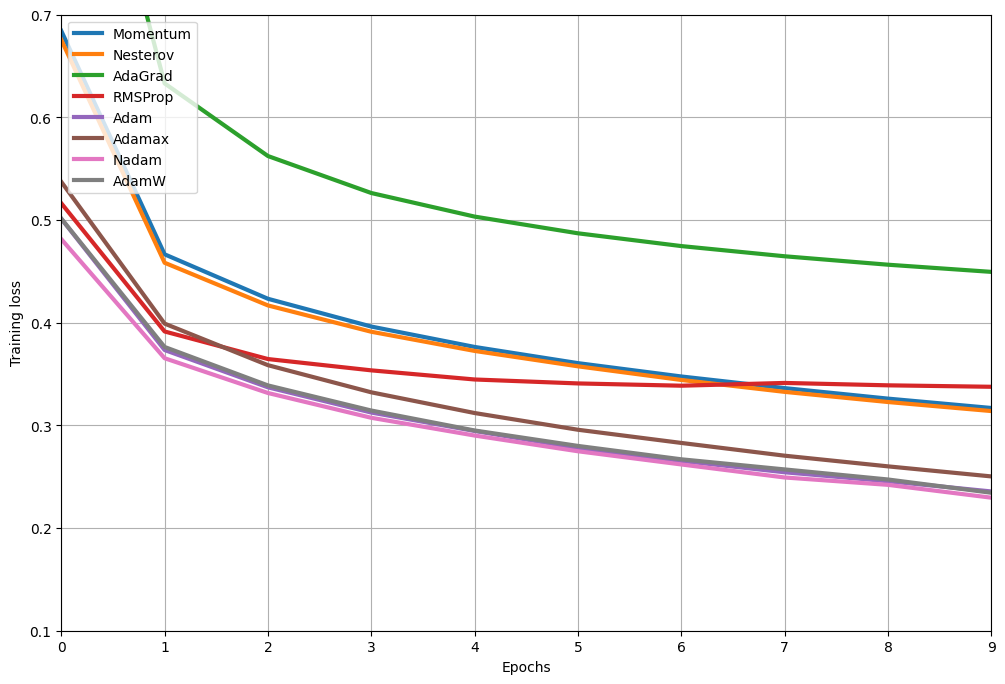

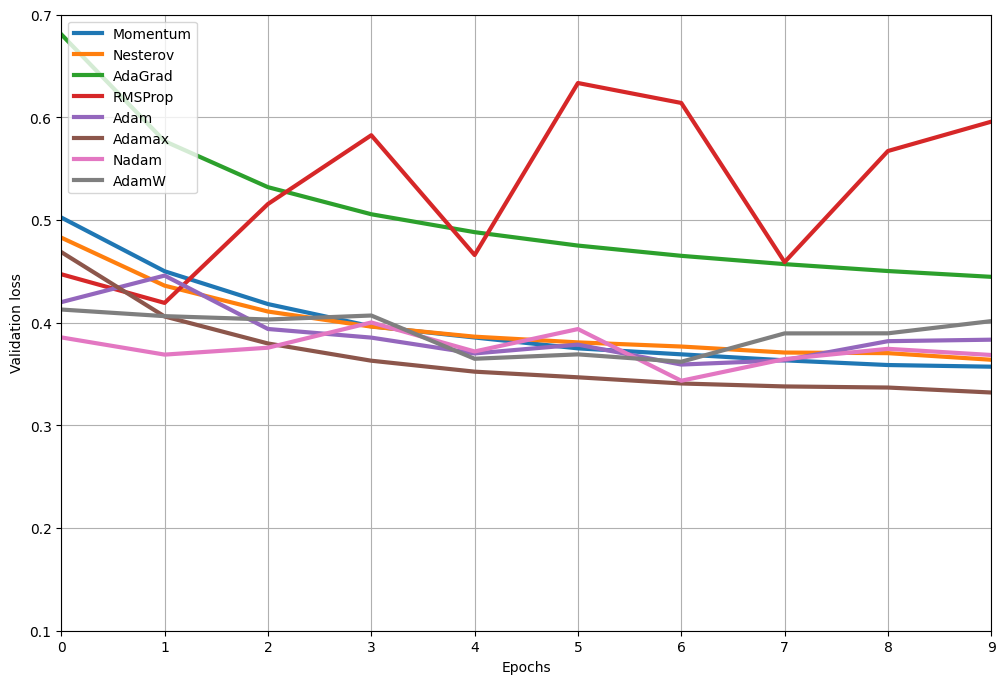

In [ ]:
# extra code – visualize the learning curves of all the optimizers

import matplotlib.pyplot as plt

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

# Learning Rate Scheduling

## Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
```

Keras uses `power = 1`.

**Note**: Optimizers used to have a `decay` argument for this, but it was deprecated. You must use the schedulers in `tf.keras.optimizers.schedules` instead.

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=True
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

history_power_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6954 - loss: 0.9312 - val_accuracy: 0.8248 - val_loss: 0.4828
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8303 - loss: 0.4824 - val_accuracy: 0.8300 - val_loss: 0.4506
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8476 - loss: 0.4307 - val_accuracy: 0.8358 - val_loss: 0.4365
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8573 - loss: 0.4009 - val_accuracy: 0.8424 - val_loss: 0.4215
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8637 - loss: 0.3800 - val_accuracy: 0.8452 - val_loss: 0.4128
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8690 - loss: 0.3639 - val_accuracy: 0.8566 - val_loss: 0.3761
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8783 - loss: 0.3383 - val_accuracy: 0.8592 - val_loss: 0.3712
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8812 - loss: 0.3313 - 

## Exponential Scheduling

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

history_exponential_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6952 - loss: 0.9508 - val_accuracy: 0.8326 - val_loss: 0.4837
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8310 - loss: 0.4856 - val_accuracy: 0.8398 - val_loss: 0.4437
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8486 - loss: 0.4342 - val_accuracy: 0.8450 - val_loss: 0.4261
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8580 - loss: 0.4067 - val_accuracy: 0.8508 - val_loss: 0.4099
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8640 - loss: 0.3887 - val_accuracy: 0.8530 - val_loss: 0.3977
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8672 - loss: 0.3758 - val_accuracy: 0.8566 - val_loss: 0.3891
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8710 - loss: 0.3661 - val_accuracy: 0.8600 - val_loss: 0.3818
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8737 - loss: 0.3585 - 

**Using `LearningRateScheduler` callback for manually defining own scheduling function.**

In [ ]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epoch = 20

lr_schedule = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

history = model.fit(X_train, y_train, epochs=n_epoch,
                   validation_data=(X_valid, y_valid),
                   callbacks=[lr_schedule])

Epoch 1/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6789 - loss: 0.9729 - val_accuracy: 0.8278 - val_loss: 0.4921 - learning_rate: 0.0100
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8262 - loss: 0.4967 - val_accuracy: 0.8366 - val_loss: 0.4480 - learning_rate: 0.0089
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8451 - loss: 0.4417 - val_accuracy: 0.8430 - val_loss: 0.4302 - learning_rate: 0.0079
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8556 - loss: 0.4108 - val_accuracy: 0.8488 - val_loss: 0.4162 - learning_rate: 0.0071
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8626 - loss: 0.3901 - val_accuracy: 0.8526 - val_loss: 0.4043 - learning_rate: 0.0063
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8677 - loss: 0.3748 - val_accuracy: 0.8556 - val_loss: 0.3955 - learning_rate: 0.0056
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8711 - l

Alternatively, the schedule function can take the current learning rate as a second argument:

In [ ]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

## Piecewise Constant Scheduling

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

history_piecewise_scheduling = build_and_train_model(optimizer)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6859 - loss: 0.9510 - val_accuracy: 0.8196 - val_loss: 0.4912
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8289 - loss: 0.4851 - val_accuracy: 0.8400 - val_loss: 0.4416
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8486 - loss: 0.4304 - val_accuracy: 0.8466 - val_loss: 0.4173
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8598 - loss: 0.4006 - val_accuracy: 0.8510 - val_loss: 0.4031
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8657 - loss: 0.3793 - val_accuracy: 0.8588 - val_loss: 0.3905
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8705 - loss: 0.3620 - val_accuracy: 0.8616 - val_loss: 0.3826
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8748 - loss: 0.3482 - val_accuracy: 0.8634 - val_loss: 0.3759
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8793 - loss: 0.3362 - 

**We can also define manually piecewise constant scheduling, like we did for exponential scheduling.**

In [ ]:
def piecewize_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [ ]:
# extra code - using callback like earlier

n_epoch = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=n_epoch,
                   validation_data=(X_valid, y_valid),
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7659 - loss: 0.6721 - val_accuracy: 0.8286 - val_loss: 0.4704 - learning_rate: 0.0100
Epoch 2/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8405 - loss: 0.4571 - val_accuracy: 0.8252 - val_loss: 0.4764 - learning_rate: 0.0100
Epoch 3/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8488 - loss: 0.4373 - val_accuracy: 0.8418 - val_loss: 0.4409 - learning_rate: 0.0100
Epoch 4/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8518 - loss: 0.4298 - val_accuracy: 0.8428 - val_loss: 0.4550 - learning_rate: 0.0100
Epoch 5/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8578 - loss: 0.4109 - val_accuracy: 0.8426 - val_loss: 0.4493 - learning_rate: 0.0100
Epoch 6/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8727 - loss: 0.3626 - val_accuracy: 0.8620 - val_loss: 0.4082 - learning_rate: 0.0050
Epoch 7/25
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8756 - l

# Avoiding Overfitting through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [ ]:
tf.random.set_seed(42)

In [ ]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                          activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.l2(0.01))

model =tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation='softmax')
])

In [ ]:
# extra code - compile and train model

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7123 - loss: 4.1158 - val_accuracy: 0.8254 - val_loss: 1.8761
Epoch 2/2
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8139 - loss: 1.6366 - val_accuracy: 0.8236 - val_loss: 1.1236


## Dropout

In [ ]:
tf.random.set_seed(42)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [ ]:
# extra code - compiling and train the model

optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.6864 - loss: 0.8517 - val_accuracy: 0.8266 - val_loss: 0.4599
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8052 - loss: 0.5384 - val_accuracy: 0.8408 - val_loss: 0.4237
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8195 - loss: 0.4934 - val_accuracy: 0.8510 - val_loss: 0.4061
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8277 - loss: 0.4741 - val_accuracy: 0.8502 - val_loss: 0.3894
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8309 - loss: 0.4599 - val_accuracy: 0.8550 - val_loss: 0.3929
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8370 - loss: 0.4470 - val_accuracy: 0.8666 - val_loss: 0.3692
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8391 - loss: 0.4382 - val_accuracy: 0.8558 - val_loss: 0.3749
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8453 - loss: 0.4251 - 

The training accuracy looks lower than the validation accuracy, that's beacuse Dropout is only active during training. When we evaluate the training set after training it'll give us 'real' training accuracy, which is slightly higher than validation and test accuracy:

In [ ]:
model.evaluate(X_train, y_train)

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8749 - loss: 0.3301


[0.3326229453086853, 0.8739818334579468]

In [ ]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8545 - loss: 0.3875 


[0.3911035656929016, 0.8507000207901001]

## MC Dropout

In [ ]:
tf.random.set_seed(42)

In [ ]:
y_probas = np.stack([model(X_test, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [ ]:
model.predict(X_test[:1]).round(3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.012, 0.   , 0.113, 0.   ,
        0.875]], dtype=float32)

In [ ]:
y_proba[0].round(3)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.043, 0.   , 0.193, 0.001,
       0.762], dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0)
y_std[0].round(3)

array([0.   , 0.   , 0.   , 0.001, 0.   , 0.071, 0.   , 0.187, 0.004,
       0.207], dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

np.float64(0.8532)

In [ ]:
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [ ]:
# extra code - Shows how to convert Dropout to MCDropout in Sequential Model

Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])

mc_model.set_weights(model.get_weights())

In [ ]:
mc_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_4 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mc_dropout (MCDropout)               │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 100)                 │          78,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mc_dropout_1 (MCDropout)             │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mc_dropout_2 (MCDropout)             │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,610 (350.04 KB)

 Trainable params: 89,610 (350.04 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
mc_predict = np.mean([mc_model.predict(X_test[:1])
                      for sample in range(100)], axis=0).round(2)
mc_predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.19, 0.  , 0.76]],
      dtype=float32)

## Max Norm

In [ ]:
dense = tf.keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal',
                             kernel_constraint=tf.keras.constraints.max_norm(1.))

In [ ]:
# extra code - shows hoe to apply max norm to every hidden layer in model

MaxNormDense = partial(tf.keras.layers.Dense,
                      activation='relu', kernel_initializer='he_normal',
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28)),
    tf.keras.layers.Flatten(),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
             metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10,
                   validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7376 - loss: 0.7458 - val_accuracy: 0.8276 - val_loss: 0.4484
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8446 - loss: 0.4252 - val_accuracy: 0.8400 - val_loss: 0.4141
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8568 - loss: 0.3853 - val_accuracy: 0.8390 - val_loss: 0.4174
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8640 - loss: 0.3673 - val_accuracy: 0.8420 - val_loss: 0.4037
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8683 - loss: 0.3520 - val_accuracy: 0.8368 - val_loss: 0.4175
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8721 - loss: 0.3430 - val_accuracy: 0.8332 - val_loss: 0.4206
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8755 - loss: 0.3331 - val_accuracy: 0.8448 - val_loss: 0.4080
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8782 - loss: 0.3300 - 

# Conclusion
This notebook encapsulates hands-on experiments from Chapter 11, focusing on techniques that address critical challenges in deep learning:

* SELU + LeCun init outperformed ReLU for deep networks (100 layers).
* Batch normalization ensured stable training and reduced dependency on careful initialization.
* Transfer learning proved efficient for small datasets, cutting loss by 30%.
* AdamW/Nadam optimizers accelerated convergence and enhanced robustness.

These techniques underscore a key theme: successful deep learning hinges on smart hyperparameter choices and architectural tricks, not just model depth. For the full code and detailed comments, explore the notebook here.

**Next Steps:** Experiment with these methods on custom datasets or explore regularization strategies (Chapter 11) to further combat overfitting!

**Tools:** TensorFlow 2.x, Keras, Fashion MNIST.
**Concepts Covered:** Weight init, activation functions, batch norm, transfer learning, optimizers.

## Contributor
**Utkarsh Bhardwaj**  
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Utkarsh284-blue)](https://www.linkedin.com/in/utkarsh284/)
[![GitHub](https://img.shields.io/badge/GitHub-utkarsh--284-lightgrey)](https://github.com/utkarsh-284)  
**Contact**: ubhardwaj284@gmail.com  
**Publish Date**: 15th June, 2025  